# 📊 Exploration des Données CIFAR-10

**Projet Deep Learning - Classification d'Images**

**Étudiant**: Ahmed Belhareth

**Module**: Deep Learning - Computer Vision

---

Ce notebook explore le dataset CIFAR-10 avant l'entraînement du modèle.

## 1. Configuration de l'Environnement

In [1]:
# Installation des dépendances (décommenter pour Google Colab)
!pip install torch torchvision matplotlib seaborn numpy pandas scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Vérifier GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## 2. Chargement du Dataset

In [3]:
# Classes CIFAR-10
CLASSES = [
    'Avion', 'Automobile', 'Oiseau', 'Chat', 'Cerf',
    'Chien', 'Grenouille', 'Cheval', 'Navire', 'Camion'
]

# Transformation basique (sans augmentation)
transform_basic = transforms.Compose([
    transforms.ToTensor()
])

# Charger les datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_basic
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_basic
)

print(f"Taille du dataset d'entraînement: {len(train_dataset)}")
print(f"Taille du dataset de test: {len(test_dataset)}")

Taille du dataset d'entraînement: 50000
Taille du dataset de test: 10000


## 3. Distribution des Classes

In [4]:
# Compter les échantillons par classe
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Créer un DataFrame
df_distribution = pd.DataFrame({
    'Classe': CLASSES,
    'Entraînement': [train_counts[i] for i in range(10)],
    'Test': [test_counts[i] for i in range(10)]
})

print("Distribution des classes:")
print(df_distribution.to_string(index=False))

Distribution des classes:
    Classe  Entraînement  Test
     Avion          5000  1000
Automobile          5000  1000
    Oiseau          5000  1000
      Chat          5000  1000
      Cerf          5000  1000
     Chien          5000  1000
Grenouille          5000  1000
    Cheval          5000  1000
    Navire          5000  1000
    Camion          5000  1000


C:\Users\Moe\AppData\Local\Temp\ipykernel_27360\3187175399.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_distribution, x='Classe', y='Entraînement', ax=axes[0], palette='viridis')
C:\Users\Moe\AppData\Local\Temp\ipykernel_27360\3187175399.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_distribution, x='Classe', y='Test', ax=axes[1], palette='viridis')


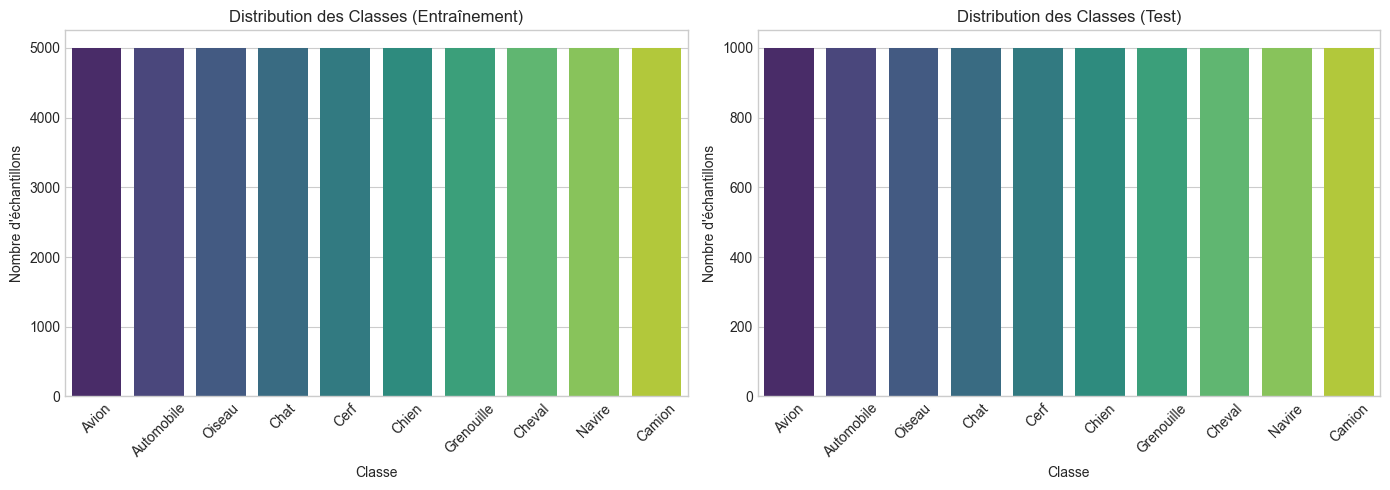


✅ Le dataset est parfaitement équilibré (5000 images par classe pour l'entraînement)


In [5]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution entraînement
sns.barplot(data=df_distribution, x='Classe', y='Entraînement', ax=axes[0], palette='viridis')
axes[0].set_title('Distribution des Classes (Entraînement)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel('Nombre d\'échantillons')

# Distribution test
sns.barplot(data=df_distribution, x='Classe', y='Test', ax=axes[1], palette='viridis')
axes[1].set_title('Distribution des Classes (Test)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel('Nombre d\'échantillons')

plt.tight_layout()
plt.savefig('distribution_classes.png', dpi=150)
plt.show()

print("\n✅ Le dataset est parfaitement équilibré (5000 images par classe pour l'entraînement)")

## 4. Visualisation d'Échantillons

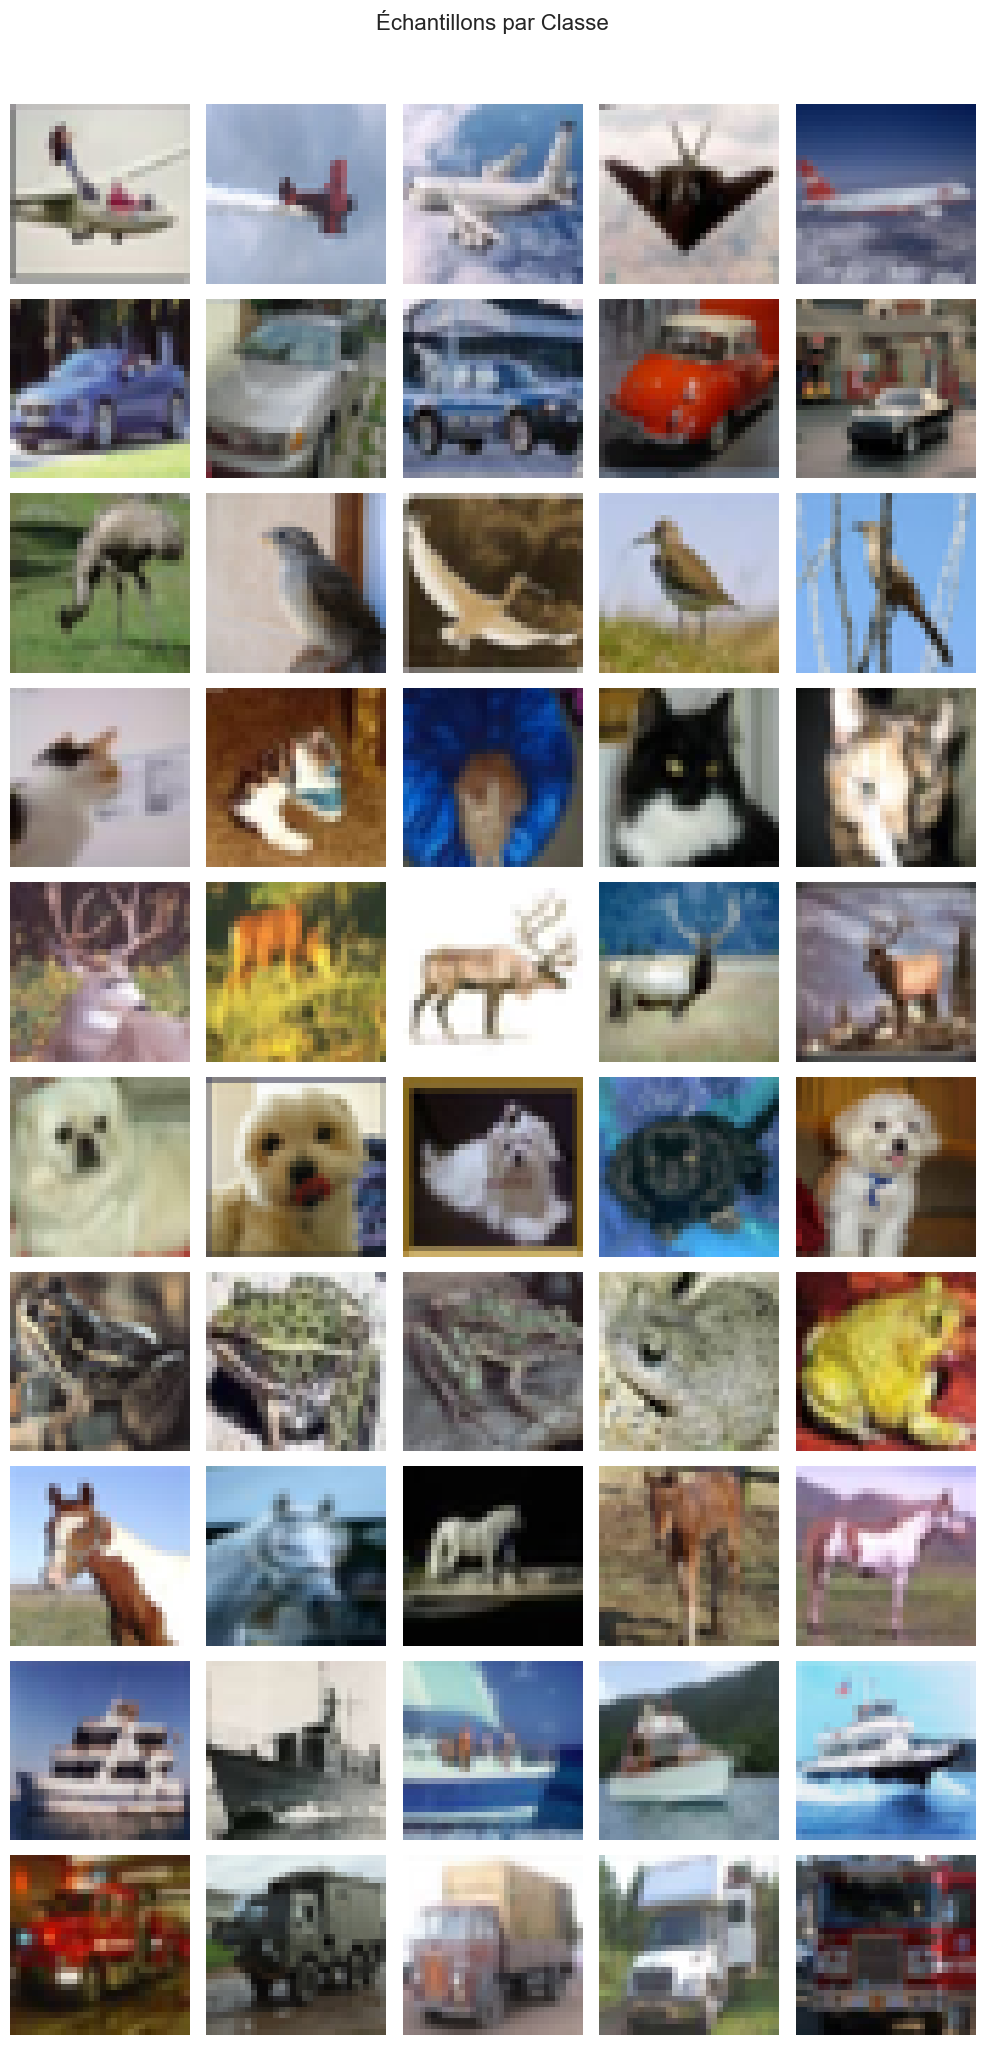

In [6]:
def show_images_grid(dataset, num_per_class=5, classes=CLASSES):
    """Affiche une grille d'images par classe."""
    fig, axes = plt.subplots(len(classes), num_per_class, figsize=(num_per_class*2, len(classes)*2))
    
    for class_idx, class_name in enumerate(classes):
        # Trouver les indices de cette classe
        indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
        selected = np.random.choice(indices, min(num_per_class, len(indices)), replace=False)
        
        for j, idx in enumerate(selected):
            img, _ = dataset[idx]
            img_np = img.permute(1, 2, 0).numpy()
            
            axes[class_idx, j].imshow(img_np)
            axes[class_idx, j].axis('off')
            
            if j == 0:
                axes[class_idx, j].set_ylabel(class_name, fontsize=12)
    
    plt.suptitle('Échantillons par Classe', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('echantillons_par_classe.png', dpi=150, bbox_inches='tight')
    plt.show()

show_images_grid(train_dataset)

## 5. Statistiques des Images

In [7]:
# Calculer les statistiques (moyenne et écart-type par canal)
def compute_dataset_stats(dataset):
    """Calcule la moyenne et l'écart-type du dataset."""
    loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=0)
    
    mean = 0.
    std = 0.
    total_samples = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples
    
    mean /= total_samples
    std /= total_samples
    
    return mean.numpy(), std.numpy()

mean, std = compute_dataset_stats(train_dataset)

print("Statistiques du dataset CIFAR-10:")
print(f"  Moyenne par canal (R, G, B): {mean}")
print(f"  Écart-type par canal (R, G, B): {std}")
print(f"\n  Valeurs standards utilisées:")
print(f"    Moyenne: [0.4914, 0.4822, 0.4465]")
print(f"    Écart-type: [0.2470, 0.2435, 0.2616]")

Statistiques du dataset CIFAR-10:
  Moyenne par canal (R, G, B): [0.49139974 0.48215848 0.44653097]
  Écart-type par canal (R, G, B): [0.20230095 0.1994128  0.2009616 ]

  Valeurs standards utilisées:
    Moyenne: [0.4914, 0.4822, 0.4465]
    Écart-type: [0.2470, 0.2435, 0.2616]


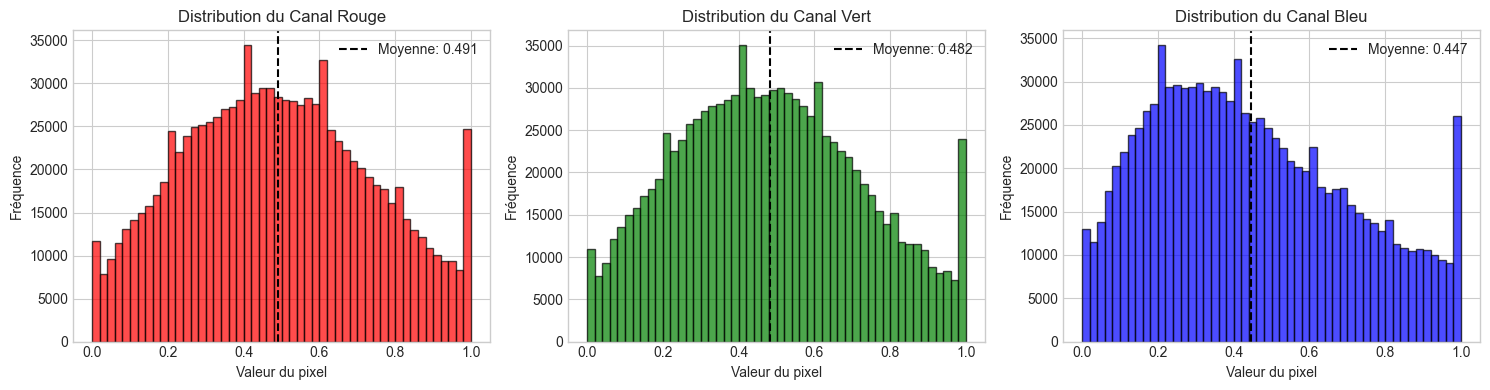

In [8]:
# Distribution des valeurs de pixels
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['red', 'green', 'blue']
channel_names = ['Rouge', 'Vert', 'Bleu']

# Prendre un échantillon d'images
sample_indices = np.random.choice(len(train_dataset), 1000, replace=False)
sample_images = torch.stack([train_dataset[i][0] for i in sample_indices])

for i, (ax, color, name) in enumerate(zip(axes, colors, channel_names)):
    channel_values = sample_images[:, i, :, :].flatten().numpy()
    ax.hist(channel_values, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribution du Canal {name}')
    ax.set_xlabel('Valeur du pixel')
    ax.set_ylabel('Fréquence')
    ax.axvline(x=mean[i], color='black', linestyle='--', label=f'Moyenne: {mean[i]:.3f}')
    ax.legend()

plt.tight_layout()
plt.savefig('distribution_pixels.png', dpi=150)
plt.show()

## 6. Analyse de la Complexité

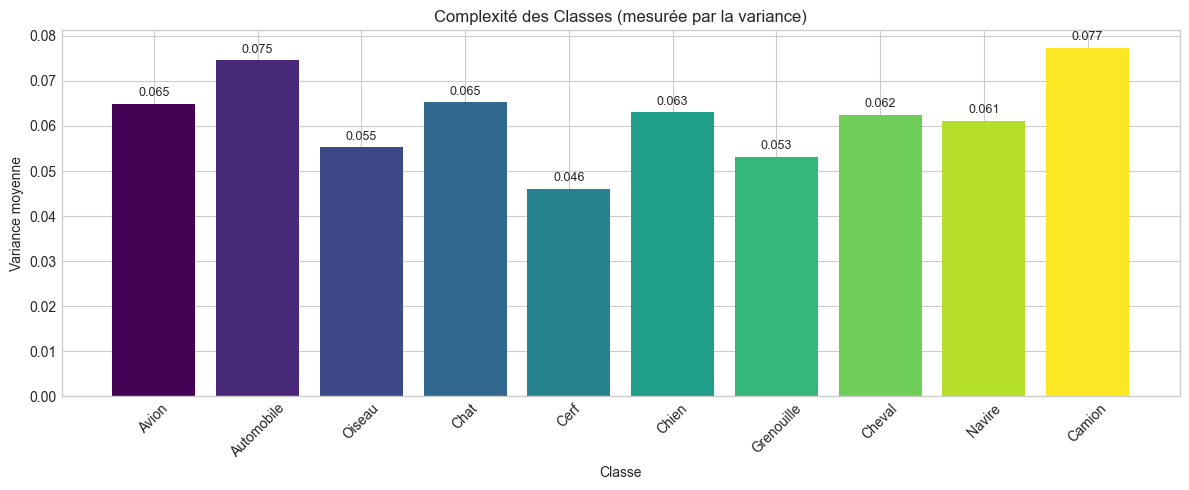

In [9]:
# Calculer la variance moyenne par classe (mesure de complexité)
def compute_class_variance(dataset, classes):
    """Calcule la variance moyenne des images par classe."""
    variances = []
    
    for class_idx in range(len(classes)):
        # Récupérer les images de cette classe
        class_images = [img for img, label in dataset if label == class_idx]
        class_tensor = torch.stack(class_images[:500])  # Échantillon
        
        # Calculer la variance
        variance = class_tensor.var().item()
        variances.append(variance)
    
    return variances

variances = compute_class_variance(train_dataset, CLASSES)

# Visualiser
plt.figure(figsize=(12, 5))
bars = plt.bar(CLASSES, variances, color=plt.cm.viridis(np.linspace(0, 1, 10)))
plt.xlabel('Classe')
plt.ylabel('Variance moyenne')
plt.title('Complexité des Classes (mesurée par la variance)')
plt.xticks(rotation=45)

for bar, var in zip(bars, variances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{var:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('complexite_classes.png', dpi=150)
plt.show()

## 7. Visualisation t-SNE (optionnel)

In [10]:
# t-SNE pour visualiser la structure des données
# Note: Cette cellule peut prendre plusieurs minutes

# Échantillonner pour la vitesse
n_samples = 2000
indices = np.random.choice(len(train_dataset), n_samples, replace=False)

images = []
labels = []
for idx in indices:
    img, label = train_dataset[idx]
    images.append(img.flatten().numpy())
    labels.append(label)

X = np.array(images)
y = np.array(labels)

print(f"Calcul t-SNE sur {n_samples} échantillons...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X)
print("Terminé!")

Calcul t-SNE sur 2000 échantillons...


Terminé!


C:\Users\Moe\AppData\Local\Temp\ipykernel_27360\1276123281.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=CLASSES[i], s=50)


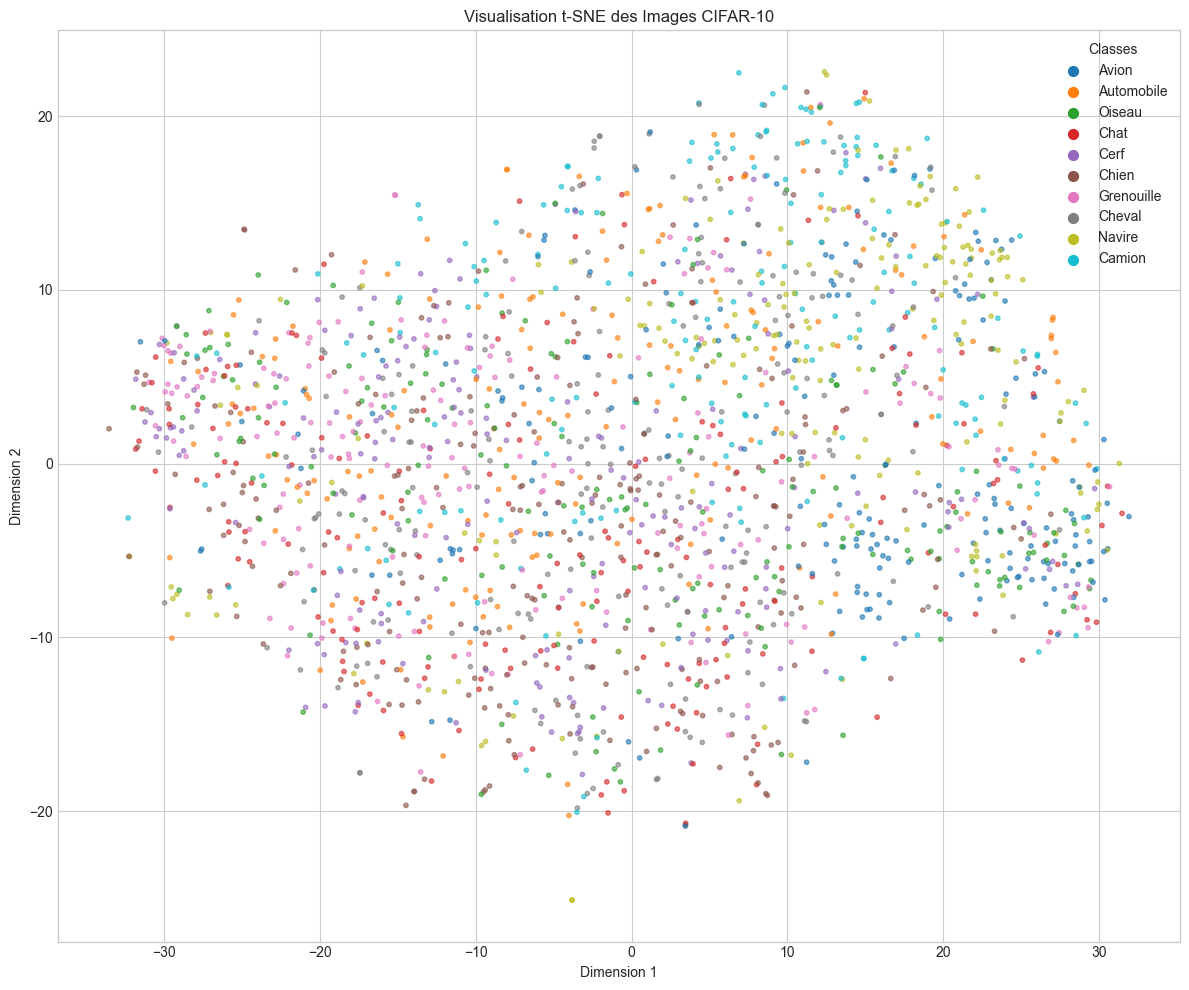

In [11]:
# Visualiser t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)

# Ajouter une légende
handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=CLASSES[i], s=50) 
           for i in range(10)]
plt.legend(handles=handles, title='Classes', loc='best')

plt.title('Visualisation t-SNE des Images CIFAR-10')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.savefig('tsne_cifar10.png', dpi=150)
plt.show()

## 8. Conclusions de l'Exploration

### Résumé des observations:

1. **Dataset équilibré**: Chaque classe contient exactement 5000 images d'entraînement et 1000 images de test.

2. **Résolution faible**: Les images sont de 32×32 pixels, ce qui limite les détails visibles.

3. **Diversité intra-classe**: Certaines classes présentent une grande variabilité (vue par la variance).

4. **Défis potentiels**:
   - Confusion possible entre Chien/Chat
   - Confusion possible entre Camion/Automobile
   - Variabilité des poses et orientations

### Recommandations pour l'entraînement:

- Utiliser des augmentations de données (flip, rotation, crop)
- Normaliser avec les statistiques CIFAR-10 calculées
- Surveiller les classes confuses lors de l'évaluation

In [12]:
# Sauvegarder les résultats
results = {
    'mean': mean.tolist(),
    'std': std.tolist(),
    'train_size': len(train_dataset),
    'test_size': len(test_dataset),
    'num_classes': 10,
    'image_size': (32, 32, 3)
}

import json
with open('exploration_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Exploration terminée! Résultats sauvegardés.")

✅ Exploration terminée! Résultats sauvegardés.
